In [1]:
import numpy as np
import os
import sys
import copy

import torch
torch.set_num_threads=4
from torch import nn
import scipy as sp

import importlib
import pickle as pk

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anm

sys.path.insert(0, "../src/")
import data
import model
import train

#import nmrglue as ng
import scipy as sp
import scipy.interpolate as ip
import scipy.optimize as op
import scipy.signal as sg

import tqdm.auto as tqdm

np.random.seed(123)

In [2]:
old_data_pars = dict(
                     # General parameters
                     td = 256, # Number of points
                     Fs = 12800, # Sampling frequency
                     debug = False, # Print data generation details

                     # Peak parameters
                     pmin = 1, # Minimum number of Gaussians in a peak
                     pmax = 1, # Maximum number of Gaussians in a peak
                     ds = 0.03, # Spread of chemical shift values for each peak
                     lw = [[5e1, 2e2], [1e2, 1e3]], # Linewidth range for Gaussians
                     iso_p = [0.8, 0.2],
                     iso_p_peakwise = True,
                     iso_int = [0.5, 1.], # Intensity
                     phase = 0., # Spread of phase

                     # Isotropic parameters
                     nmin = 1, # Minimum number of peaks
                     nmax = 15, # Maximum number of peaks
                     shift_range = [2000., 10000.], # Chemical shift range
                     positive = True, # Force the spectrum to be positive

                     # MAS-dependent parameters
                     mas_g_range = [[1e10, 1e11], [1e10, 5e11]], # MAS-dependent Gaussian broadening range
                     mas_l_range = [[1e7, 1e8], [1e7, 5e8]], # MAS-dependent Lorentzian broadening range
                     mas_s_range = [[-1e7, 1e7], [-1e7, 1e7]], # MAS-dependent shift range
                     mas_p = [0.8, 0.2],

                     # Second-order MAS-dependent parameters
                     mas_w2 = False,
                     mas_w2_p = 1.,
                     mas2_g_range = [[1e13, 1e15], [1e15, 1e16]], # MAS-dependent Gaussian broadening range
                     mas2_l_range = [[1e10, 1e12], [1e12, 1e13]], # MAS-dependent Lorentzian broadening range
                     mas2_s_range = [[-2e11, 2e11], [-2e11, 2e11]], # MAS-dependent shift range
                     mas2_p = [0.8, 0.2],

                     mas_phase = 0.1, # Random phase range for MAS spectra
                     peakwise_phase = True, # Whether the phase should be peak-wise or spectrum-wise
                     encode_imag = False, # Encode the imaginary part of the MAS spectra
                     nw = 24, # Number of MAS rates
                     mas_w_range = [30000, 100000], # MAS rate range
                     random_mas = True,
                     encode_w = True, # Encode the MAS rate of the spectra

                     # Post-processing parameters
                     noise = 0., # Noise level
                     smooth_end_len = 10, # Smooth ends of spectra
                     iso_norm = 256., # Normalization factor for peaks
                     brd_norm = 64., # Normalization factor for MAS spectra
                     offset = 0., # Baseline offset
                     norm_wr = True, # Normalize MAS rate values
                     wr_inv = False # Encode inverse of MAS rate instead of MAS rate
                    )

In [3]:
old_dataset = data.PIPDataset(**old_data_pars)

In [4]:
%%timeit
_ = old_dataset.__getitem__(0)

583 ms ± 225 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [478]:
data_pars = dict(
                 # General parameters
                 td = 256, # Number of points
                 Fs = 12800, # Sampling frequency
                 debug = False, # Print data generation details

                 # Peak parameters
                 pmin = 1, # Minimum number of Gaussians in a peak
                 pmax = 1, # Maximum number of Gaussians in a peak
                 ds = 0.03, # Spread of chemical shift values for each peak
                 lw = [[5e1, 2e2], [1e2, 1e3]], # Linewidth range for Gaussians
                 iso_p = [0.8, 0.2],
                 iso_p_peakwise = True,
                 iso_int = [0.5, 1.], # Intensity
                 phase = 0., # Spread of phase

                 # Isotropic parameters
                 nmin = 1, # Minimum number of peaks
                 nmax = 15, # Maximum number of peaks
                 shift_range = [2000., 10000.], # Chemical shift range
                 positive = True, # Force the spectrum to be positive
    
                 # MAS-independent parameters
                 mas0_lw_range = [0., 0.], # MAS-independent GLS broadening range
                 mas0_lw_p = [1.],
                 mas0_m_range = [[0., 0.1], [0., 1.]], # MAS-independent GLS mixing paramter
                 mas0_m_p = [0.8, 0.2],
                 mas0_s_range = [0., 0.], # MAS-independent shift range
                 mas0_s_p = [1.],

                 # MAS-dependent parameters
                 mas_lw_range = [[1e7, 1e8], [5e7, 2e8]], # MAS-dependent GLS broadening range
                 mas_lw_p = [0.8, 0.2],
                 mas_m_range = [[1e4, 5e4]], # MAS-dependent GLS mixing paramter
                 mas_m_p = [1.],
                 mas_s_range = [-1.5e7, 1.5e7], # MAS-dependent shift range
                 mas_s_p = [1.],

                 # Second-order MAS-dependent parameters
                 mas_w2 = False,
                 mas_w2_p = 1.0,
                 mas2_lw_range = [[1e2, 1e4], [1e8, 1e9]], # Second-order MAS-dependent Gaussian broadening range
                 mas2_lw_p = [0.5, 0.5],
                 mas2_m_range = [[0., 10], [1e4, 1e6]], # Second-order MAS-dependent Lorentzian broadening range
                 mas2_m_p = [0.5, 0.5],
                 mas2_s_range = [[0., 0.], [-2e11, 2e11]], # Second-order MAS-dependent shift range
                 mas2_s_p = [0.8, 0.2],

                 mas_phase = 0.01, # Random phase range for MAS spectra
                 peakwise_phase = True, # Whether the phase should be peak-wise or spectrum-wise
                 encode_imag = False, # Encode the imaginary part of the MAS spectra
                 nw = 24, # Number of MAS rates
                 mas_w_range = [30000, 100000], # MAS rate range
                 random_mas = True,
                 encode_w = True, # Encode the MAS rate of the spectra

                 # Post-processing parameters
                 noise = 0., # Noise level
                 smooth_end_len = 10, # Smooth ends of spectra
                 iso_norm = 256., # Normalization factor for peaks
                 brd_norm = 64., # Normalization factor for MAS spectra
                 offset = 0., # Baseline offset
                 norm_wr = True, # Normalize MAS rate values
                 wr_inv = False # Encode inverse of MAS rate instead of MAS rate
                )

In [479]:
importlib.reload(data)

dataset = data.PIPDatasetGLS(**data_pars)

In [480]:
brd_specs, specs, iso = dataset.__getitem__(0)

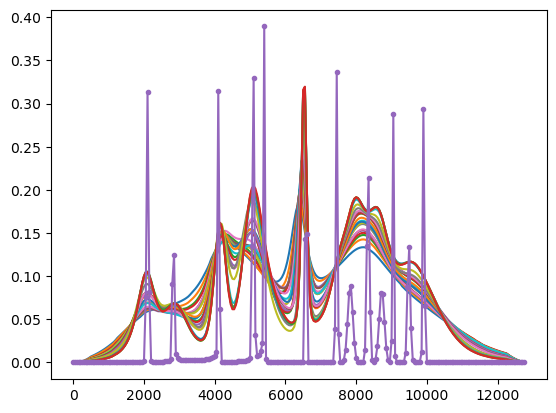

In [485]:
brd_specs, specs, iso = dataset.__getitem__(0)
plt.plot(dataset.f, brd_specs[:, 0, :].T)
plt.plot(dataset.f, iso[0], ".-")
#plt.xlim(8000, 10000)
plt.show()
plt.close()

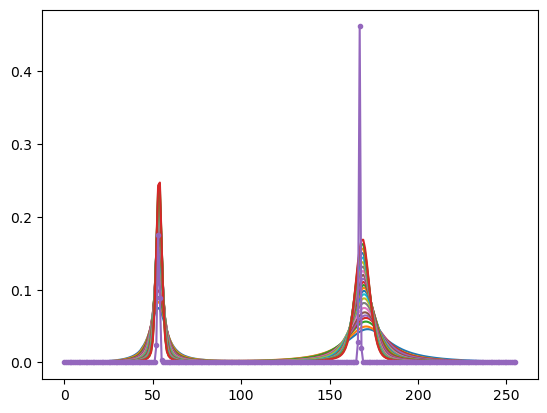

In [301]:
plt.plot(brd_specs[:, 0, :].T)
plt.plot(iso[0], ".-")
#plt.xlim(8000, 10000)
plt.show()
plt.close()

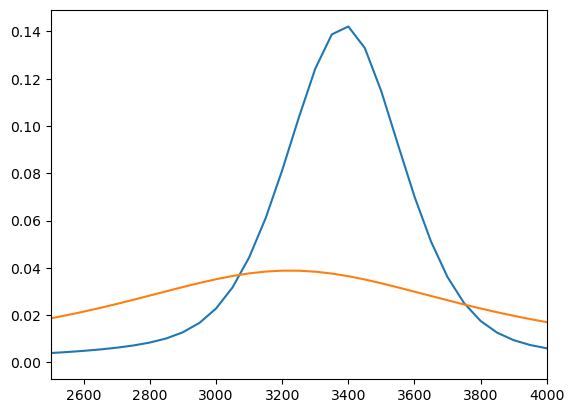

In [250]:
plt.plot(dataset.f, brd_specs[-1, 0])
plt.plot(dataset.f, brd_specs[0, 0])
#plt.plot(dataset.f, iso[0], ".-")
plt.xlim(2500, 4000)
plt.show()
plt.close()